In [2]:
import torch
import torch_geometric
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from scipy.stats import ortho_group
from collections import Counter

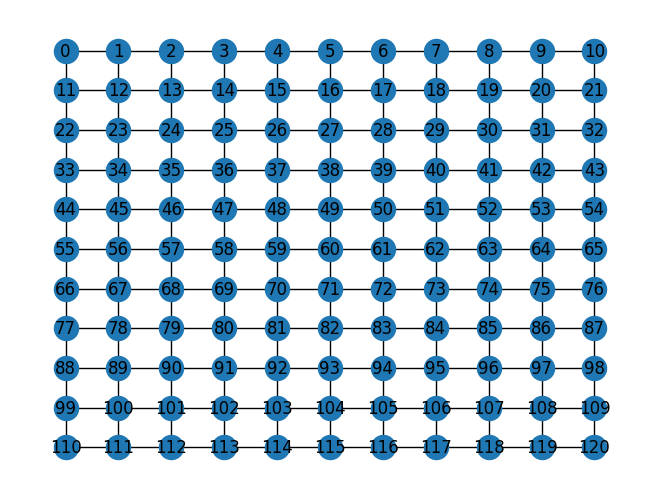

In [3]:
# create a 2D grid graph
k = 11
grid = nx.grid_2d_graph(k, k)
n = k * k
grid = nx.convert_node_labels_to_integers(grid)

# make grid undirected
grid = grid.to_undirected()
# add edges in the opposite direction
# grid.add_edges_from([(v, u) for (u, v) in grid.edges()])

# plot the graph
# create 2D coordinates
pos = dict()
for i in range(k):
    for j in range(k):
        pos[i * k + j] = (j, -i)

nx.draw(grid, pos=pos, with_labels=True)

C:\Users\guyle\AppData\Local\Temp\ipykernel_22036\475487089.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("coolwarm")
C:\Users\guyle\AppData\Local\Temp\ipykernel_22036\475487089.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


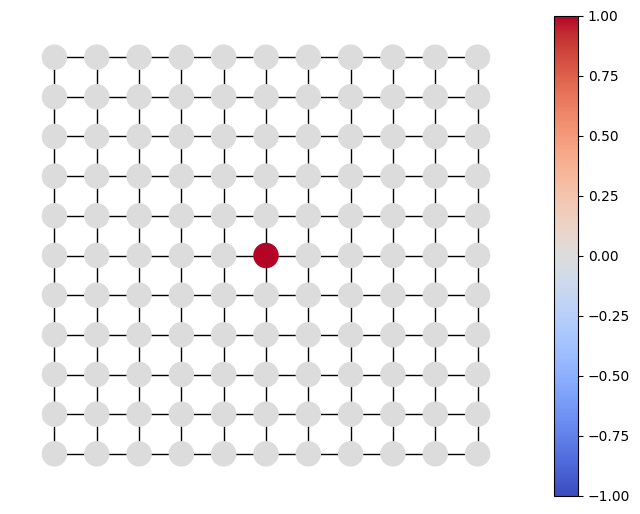

In [4]:
edges = list(grid.edges)
# add edges in the opposite direction
edges.extend([(v, u) for (u, v) in grid.edges()])

edge_index = torch.tensor(edges).t().contiguous()
x = torch.tensor(np.zeros((n, 1)), dtype=torch.float)
# x will be a spike signal in the middle of the grid
x[(n - 1)//2] = 1
# x[42] = -1
data = Data(x=x, edge_index=edge_index)

# create colormap that distinguishes between positive and negative values
cmap = plt.cm.get_cmap("coolwarm")

# node_color = [cmap(x) for x in data.x]

# visualize the spike signal
nx.draw(grid, pos=pos, node_color=data.x, cmap=cmap, with_labels=False, vmin=-1, vmax=1)
# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm)


## ChebConv spectral filter (isotropic)
### Using PyTorch Geometric

C:\Users\guyle\AppData\Local\Temp\ipykernel_22036\1775735775.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


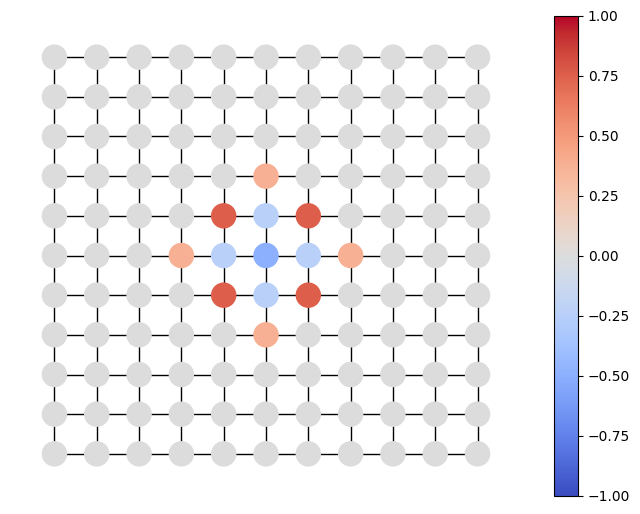

In [5]:
from torch_geometric.nn import ChebConv
# define a filter on a graph using pytorch geometric
class Filter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ChebConv(1, 1, K=4, bias=False, normalization='rw')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return x
 
filter = Filter()
# set the filter weights
set_param_to = np.array([[1],[1],[3],[0]], dtype=np.float32)

for idx, param in enumerate(filter.conv1.parameters()):
    param.data = torch.tensor(set_param_to[idx])

# for param in filter.conv1.parameters():
#     print(param)

out = filter(data)

# visualize the output

nx.draw(grid, pos=pos, node_color=out.detach().numpy(), with_labels=False, cmap="coolwarm", vmin=-1, vmax=1)
# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm)
plt.show()


## Building the spectral filter explicitly
### Simple polynomial filter (isotropic)
$Cf = \mathcal{F}^* \mathcal{D}_{g(\Lambda)} \mathcal{F} f$

C:\Users\guyle\AppData\Local\Temp\ipykernel_22036\3566196688.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


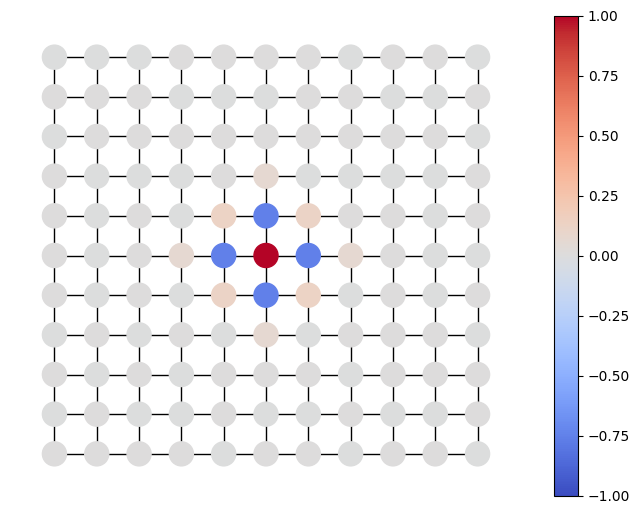

In [6]:
# explicit spectral graph filter
L = nx.normalized_laplacian_matrix(grid)
L = L.todense()
eigenvalues, eigenvectors = np.linalg.eigh(L)
g = lambda x, a0, a1, a2: a0 + a1 * x + a2 * x**2 
D = np.diag(g(eigenvalues, 1, 1, 1))
spectral_filter = eigenvectors @ D @ eigenvectors.T
output = spectral_filter @ x.numpy()
# visualize the output

nx.draw(grid, pos=pos, node_color=output, with_labels=False, cmap="coolwarm", vmin=-1, vmax=1)
# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm)
plt.show()

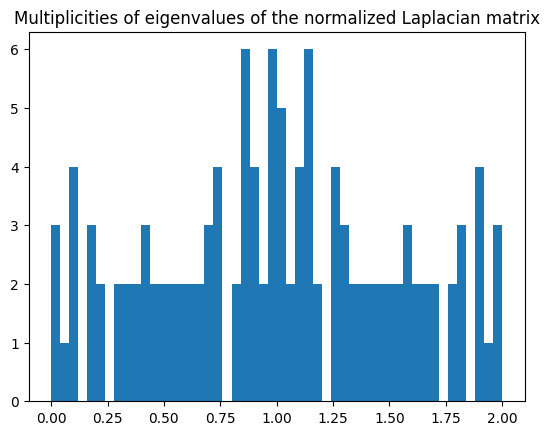

In [10]:
# plot histogram of eigenvalues
plt.hist(eigenvalues, bins=50)
plt.title('Multiplicities of eigenvalues of the normalized Laplacian matrix')
plt.show()

In [8]:
def construct_block_diagonal_ortho(eigenvalues, round_precision=3):
    eigenvalues_round = np.round(eigenvalues, round_precision)
    cntr = Counter(eigenvalues_round)
    n = len(eigenvalues)
    R = np.zeros((n, n))
    next_start_from = 0

    for val in np.unique(eigenvalues_round):
        multiplicity = cntr[val]
        if multiplicity == 1:
            R[next_start_from, next_start_from] = 1
        else:
            R[next_start_from:next_start_from + multiplicity, next_start_from:next_start_from + multiplicity] = ortho_group.rvs(dim=multiplicity)
        next_start_from += multiplicity

    return R

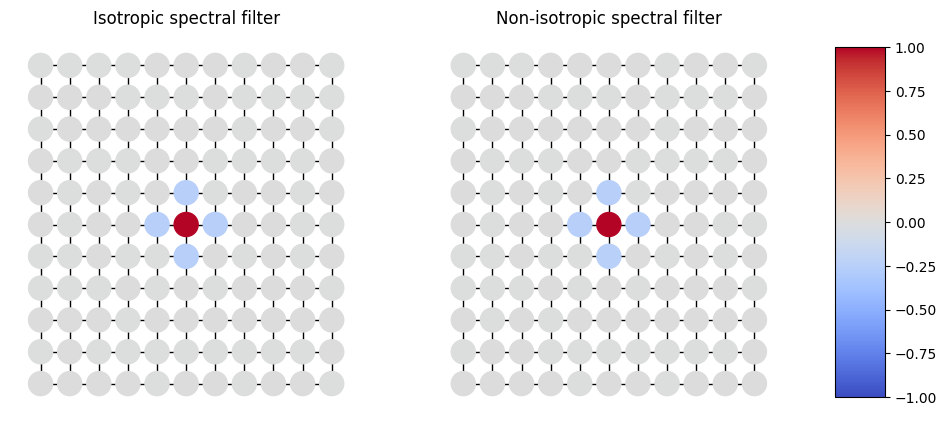

In [9]:
#

# np.random.seed(0)
# create a random orthogonal matrix
# Q = ortho_group.rvs(dim=n)
Q = construct_block_diagonal_ortho(eigenvalues)
# add small noise to non-zero entries in Q
# Q[Q != 0] += np.random.normal(0, 0.1, Q[Q != 0].shape)

D = np.diag(g(eigenvalues, 1, 1, 0))

isotropic_spectral_filter = eigenvectors @ D @ eigenvectors.T
non_isotropic_spectral_filter = eigenvectors @ Q @ D @ Q.T @ eigenvectors.T # IS THE SAME AS ISOTROPIC WHEN Q IS CONSTRUCTED LIKE WE SUGGESTED
# non_isotropic_spectral_filter = eigenvectors @ Q @ eigenvectors.T @ D @ eigenvectors @ Q.T @ eigenvectors.T # DOES NOT WORK

output_iso = isotropic_spectral_filter @ x.numpy()
output_non_iso = non_isotropic_spectral_filter @ x.numpy()
# visualize the output

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

nx.draw(grid, pos=pos, node_color=output_iso, with_labels=False, cmap="coolwarm", vmin=-1, vmax=1, ax=ax[0])
ax[0].set_title('Isotropic spectral filter')
nx.draw(grid, pos=pos, node_color=output_non_iso, with_labels=False, cmap="coolwarm", vmin=-1, vmax=1, ax=ax[1])
ax[1].set_title('Non-isotropic spectral filter')

# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
# add a custom small axis for the colorbar
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(sm, cax=cbar_ax)
plt.show()